<a href="https://colab.research.google.com/github/drshaheed/Predicting-Customer-Churn-with-Logistic-Regression/blob/main/Customer_Churn_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install pycaret
!pip install pycaret

In [2]:
# import libraries
import pandas as pd
import numpy as np# read csv data
data = pd.read_csv('https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv')

# Exploratory Data Analysis

In [3]:
# check data types
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
# replace blanks with np.nan
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)# convert to float64
data['TotalCharges'] = data['TotalCharges'].astype('float64')

Notice that TotalCharges is of an object type instead of float64. Upon investigation, I figured out there are some blank spaces in this column which has caused Python to force the data type as object . To fix that, we will have to trim blank spaces before changing the data type.

Intuitively contract type, tenure (length of stay of the customer), and pricing plans are very important information when it comes to customer churn or retention. Let’s explore the relationship:

In [5]:
import plotly.express as px

fig = px.scatter(x=data['tenure'], y=data['TotalCharges'], 
                 color = data['Churn'], template = 'presentation', 
                 opacity = 0.5, facet_col = data['Contract'], 
                 title = 'Customer Churn by Tenure, Charges, and Contract Type',
                 labels = {'x' : 'Customer Tenure', 'y' : 'Total Charges $'})
                
fig.show()

Note that most churn can be seen in the contracts that are “Month-to-Month”. Makes sense, ofcourse. Also, I can see that as the tenure increases and so are the total charges, the likelihood of customers with high tenure and low charges is less compared to customers with high tenure and high charges.

# Dealing Missing Values

In [6]:
# check missing values
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Note that because we replaced blank values with np.nan there are now 11 rows with missing values in TotalCharges. No problem — I will leave it with PyCaret to impute it automatically.

# Data Preparation

Common to all modules in PyCaret, the setup is the first and the only mandatory step in any machine learning experiment performed in PyCaret. This function takes care of all the data preparation required prior to training models. Besides performing some basic default processing tasks, PyCaret also offers a wide array of pre-processing features. To learn more about all the preprocessing functionalities in PyCaret

In [7]:
# initial setup
from pycaret.classification import *
s = setup(data, target = 'Churn', ignore_features = ['customerID'])

,Description,Value
0,Session id,5266
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7043, 21)"
5,Transformed data shape,"(7043, 41)"
6,Transformed train set shape,"(4930, 41)"
7,Transformed test set shape,"(2113, 41)"
8,Ignore features,1
9,Ordinal features,5


Whenever you initialize the setup function in PyCaret, it profiles the dataset and infers the data types for all input features. In this case, we can see except for tenure MonthlyCharges and TotalCharges , everything else is categorical, which is correct, we can now press enter to continue. If data types are not inferred correctly (which can happen sometimes), we can use numeric_feature and categorical_feature to overwrite the data types.

Also, I have passed ignore_features = ['customerID'] in the setup function so that it is not considered when training the models. The good thing about this is PyCaret will not remove the column from the dataset, it will just ignore it behind the scene for model training. As such when you generate predictions at the end, you don’t need to worry about joining IDs back by yourself.

# Model Training & Selection

Now that data preparation is done, let’s start the training process by using compare_models functionality. This function trains all the algorithms available in the model library and evaluates multiple performance metrics using cross-validation.

In [9]:
# compare all models
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8057,0.8487,0.5199,0.6728,0.5853,0.4615,0.4687,0.5510
ada,Ada Boost Classifier,0.7988,0.8440,0.5184,0.6524,0.5770,0.4474,0.4529,0.4350
lr,Logistic Regression,0.8059,0.8419,0.5444,0.6635,0.5975,0.4714,0.4757,1.2330
lightgbm,Light Gradient Boosting Machine,0.7972,0.8375,0.5107,0.6492,0.5708,0.4408,0.4467,0.3330
lda,Linear Discriminant Analysis,0.7953,0.8335,0.5459,0.6329,0.5857,0.4509,0.4534,0.4290
xgboost,Extreme Gradient Boosting,0.7872,0.8253,0.5100,0.6208,0.5589,0.4207,0.4248,0.2770
rf,Random Forest Classifier,0.7970,0.8209,0.5015,0.6536,0.5662,0.4369,0.4442,0.4700
qda,Quadratic Discriminant Analysis,0.6513,0.8176,0.8440,0.4260,0.5609,0.3232,0.3830,0.4040
nb,Naive Bayes,0.6892,0.8144,0.8409,0.4539,0.5895,0.3736,0.4200,0.2720
et,Extra Trees Classifier,0.7746,0.7896,0.4686,0.5965,0.5235,0.3791,0.3845,0.6060


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [10]:
# print best_model parameters
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=5266, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


# Hyperparameter Tuning

we can use the tune_model function from PyCaret to automatically tune the hyperparameters of the model.

In [12]:
# tune best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8114,0.8415,0.5154,0.6907,0.5903,0.4711,0.4796
1,0.7931,0.8455,0.4538,0.6556,0.5364,0.4088,0.4203
2,0.7890,0.8313,0.4733,0.6392,0.5439,0.4106,0.4184
3,0.8093,0.8609,0.5496,0.6729,0.6050,0.4811,0.4853
4,0.8235,0.8596,0.6107,0.6897,0.6478,0.5306,0.5324
5,0.7911,0.8227,0.4962,0.6373,0.5579,0.4239,0.4296
6,0.8114,0.8596,0.5115,0.6979,0.5903,0.4715,0.4811
7,0.8093,0.8417,0.5038,0.6947,0.5841,0.4644,0.4745
8,0.8053,0.8652,0.4809,0.6923,0.5676,0.4471,0.4595


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Now the AUC has slightly increased from *0.8472 to 0.8478*

# Model Analysis

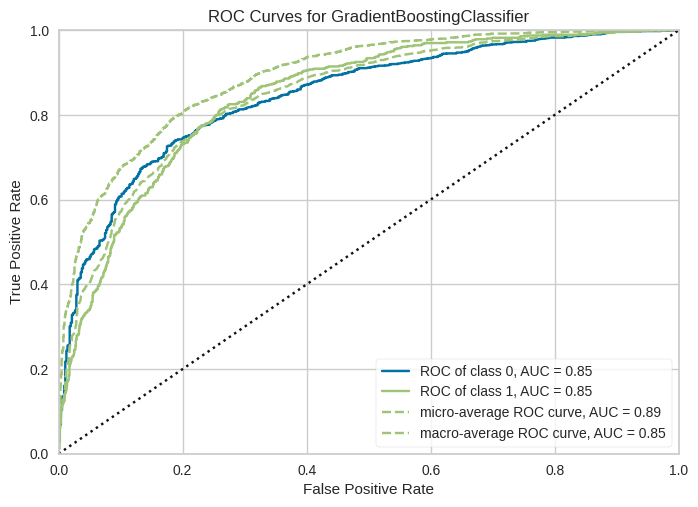

In [13]:
# AUC Plot
plot_model(tuned_best_model, plot = 'auc')

# Feature Importance Plot

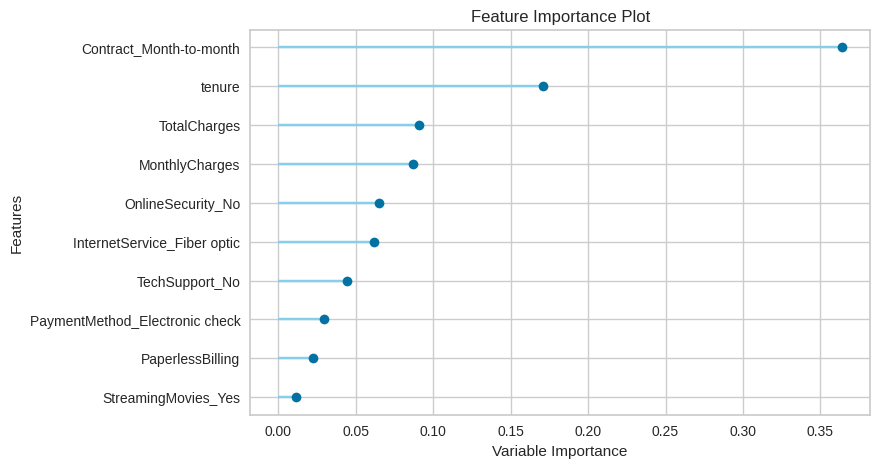

In [16]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

# Confusion Matrix

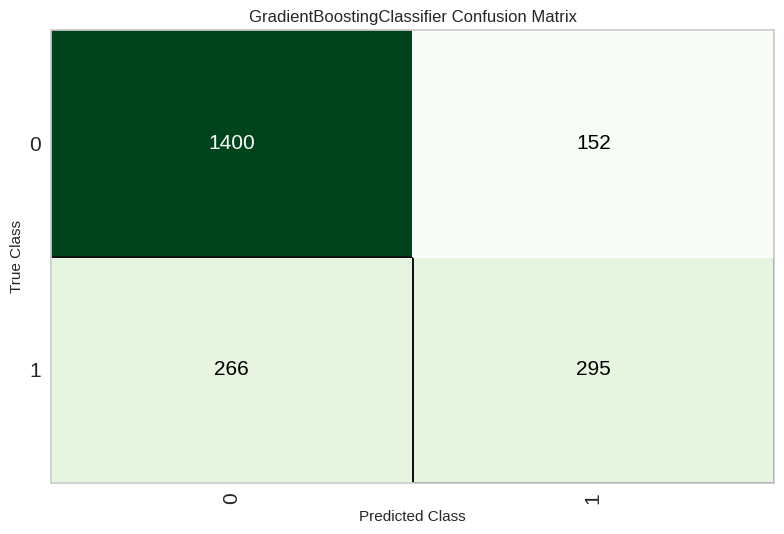

In [17]:
# Confusion Matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')

This confusion matrix is on the test set which includes 30% of our data (2,113 rows) We have 309 True Positives (15%) — these are the customers for which we will be able to extend the lifetime value. If we wouldn’t have predicted, then there was no opportunity for intervention.

We also have 138 (7%) False Positives where we will lose money because the promotion offered to these customers will just be an extra cost.

1,388 (66%) are True Negatives (good customers) and 278 (13%) are False Negative (this is a missed opportunity).

So far we have trained multiple models to select the best model giving the highest AUC, followed by tuning the hyperparameters of the best model to squeeze a little more performance in terms of AUC. However, the best AUC doesn’t necessarily translate into the best model for business.

In a churn model, often the reward of true positives is way different than the cost of false positives. Let’s use the following assumptions:

    $1,000 voucher will be offered to all the customers identified as churn (True Positive + False Positive);
    If we are able to stop the churn, we will gain $5,000 in customer lifetime value.